# Churn prediction

## Project description

Within the scope of the current research, an analysis of customer data of the telecommunications operator is being conducted. The company aims to have the ability to predict customer churn in order to differentiate between 'loyal' and 'disloyal' customers. The latter are planned to be incentivized by means of special offers and promo codes.

As part of the study, there are several datasets available concerning contracts, personal information, internet services, and telephone services.

**Goal**: forecasting customer churn of the telecommunications operator.

## Plan

1. Data Preprocessing \
    1.1  Study of the original data \
    1.2  New features adding \
    1.3  Data integration \
    1.4  Handling missing values 
    
    
2. Data Analysis \
    2.1  Visualization of all key features \
    2.2  Variable correlations variables
    
3. Data preparation for training \
    3.1 Removal of unnecessary variables \
    3.2 Processing of categorical variables \
    3.3 Division of training and testing datasets \
    3.4 Processing of quantitative variables
    3.5 Class imbalance check 
    
4. Model training \
    4.1  RandomForestClassifier \
    4.2  CatBoostClassifier \
    4.3  Selection of the best model 
    
5. Best model validation \
    5.1 Validation of the best model on the test sample \
    5.2 Calculation of key quality metrics  

6. Conclusion

## Data Preprocessing

Importing the libraries necessary for further analysis and model building.

In [1]:
conda install -c conda-forge lightgbm

Solving environment: / 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - conda-forge/osx-64::lightgbm==3.3.5=py310h879db79_0
done


==> WARNING: A newer version of conda exists. <==
  current version: 23.1.0
  latest version: 23.7.2

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.7.2



## Package Plan ##

  environment location: /Users/aasheremeeva/anaconda3

  added / updated specs:
    - lightgbm


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2023.7.22  |       h8857fd0_0         146 KB  conda-forge
    certifi-2023.7.22          |     pyhd8ed1ab_0         150 KB  conda-forge
    openssl-1.1.1v             |       h8a1eda9_0         1.7 MB  conda-forge
    

In [2]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time
import lightgbm as lgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier

In [5]:
contract = pd.read_csv('/Users/aasheremeeva/Desktop/All DS Projects/churn prediction/contract_new.csv')
internet = pd.read_csv('/Users/aasheremeeva/Desktop/All DS Projects/churn prediction/internet_new.csv')
personal = pd.read_csv('/Users/aasheremeeva/Desktop/All DS Projects/churn prediction/personal_new.csv')
phone = pd.read_csv('/Users/aasheremeeva/Desktop/All DS Projects/churn prediction/phone_new.csv')

To start, let's examine the structure of the source data and the information available about the company's customers.

### Study of the original data

In [6]:
def analysis(data):
    data.info()
    display(data)
    display(data.describe())


In [7]:
analysis(contract)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5
...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,2035.2
7039,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7430.4
7040,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,325.6
7041,8361-LTMKD,2019-07-01,No,Month-to-month,Yes,Mailed check,74.40,520.8


,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


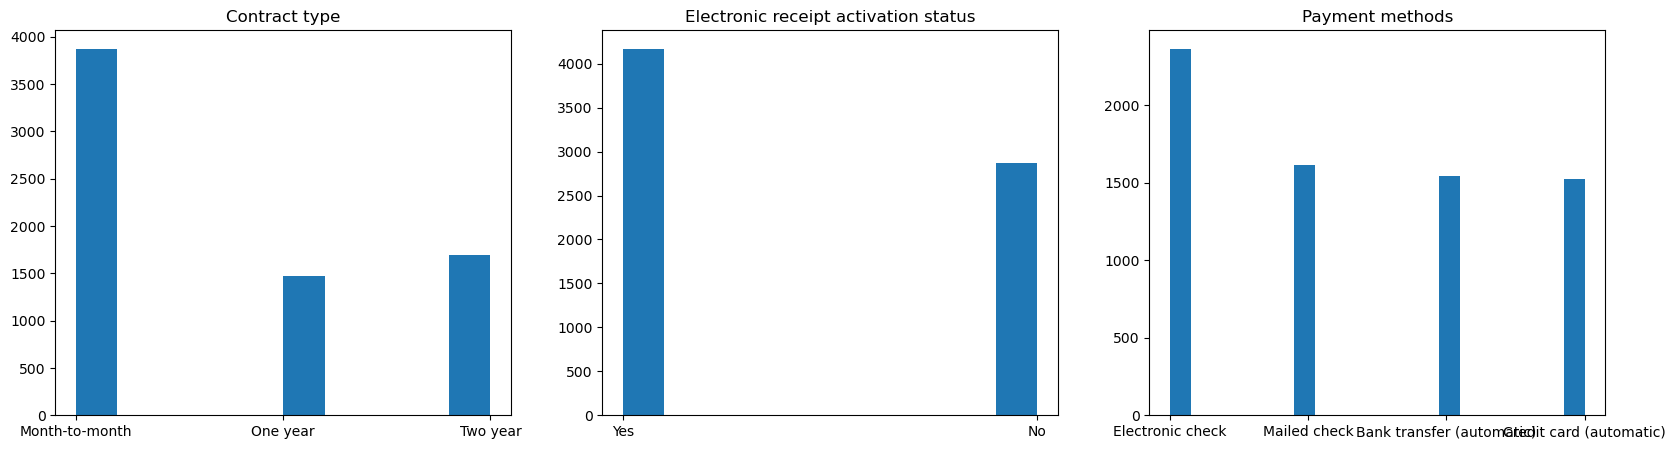

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(20,5))

axs[0].hist(contract['Type'], bins = 10, label='x')
axs[0].set_title('Contract type')

axs[1].hist(contract['PaperlessBilling'], bins = 10, label='x')
axs[1].set_title('Electronic receipt activation status')

axs[2].hist(contract['PaymentMethod'], bins = 20, label='x')
axs[2].set_title('Payment methods')

plt.show()

**Conclusions on the "Contract" dataset**
* No missing values found.
* The data types of the variables `Begindate` and `Enddate` need to be changed from 'object' to 'date'.
* For the `Enddate` column, the 'No' values should be replaced with '01.02.2020'.
* The majority of customers have contracts with a monthly payment type for services.
* More customers avail the option of receiving electronic receipts.
* Most customers make payments using electronic receipts, while the rest of the customers are almost evenly distributed among the remaining three payment methods (postal check, bank transfer, credit card).

In [9]:
analysis(internet)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...
5512,6840-RESVB,DSL,Yes,No,Yes,Yes,Yes,Yes
5513,2234-XADUH,Fiber optic,No,Yes,Yes,No,Yes,Yes
5514,4801-JZAZL,DSL,Yes,No,No,No,No,No
5515,8361-LTMKD,Fiber optic,No,No,No,No,No,No


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,7590-VHVEG,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


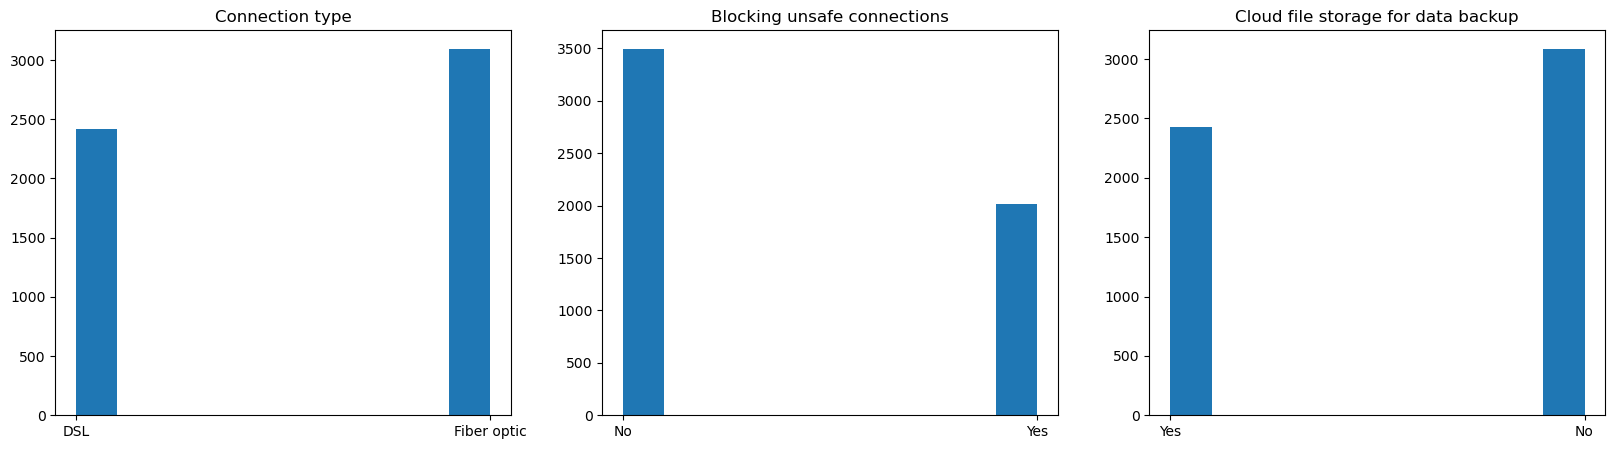

In [10]:
fig, axs = plt.subplots(1, 3, figsize=(20,5))

axs[0].hist(internet['InternetService'], bins = 10, label='x')
axs[0].set_title('Connection type')

axs[1].hist(internet['OnlineSecurity'], bins = 10, label='x')
axs[1].set_title('Blocking unsafe connections')

axs[2].hist(internet['OnlineBackup'], bins = 10, label='x')
axs[2].set_title('Cloud file storage for data backup')

plt.show()

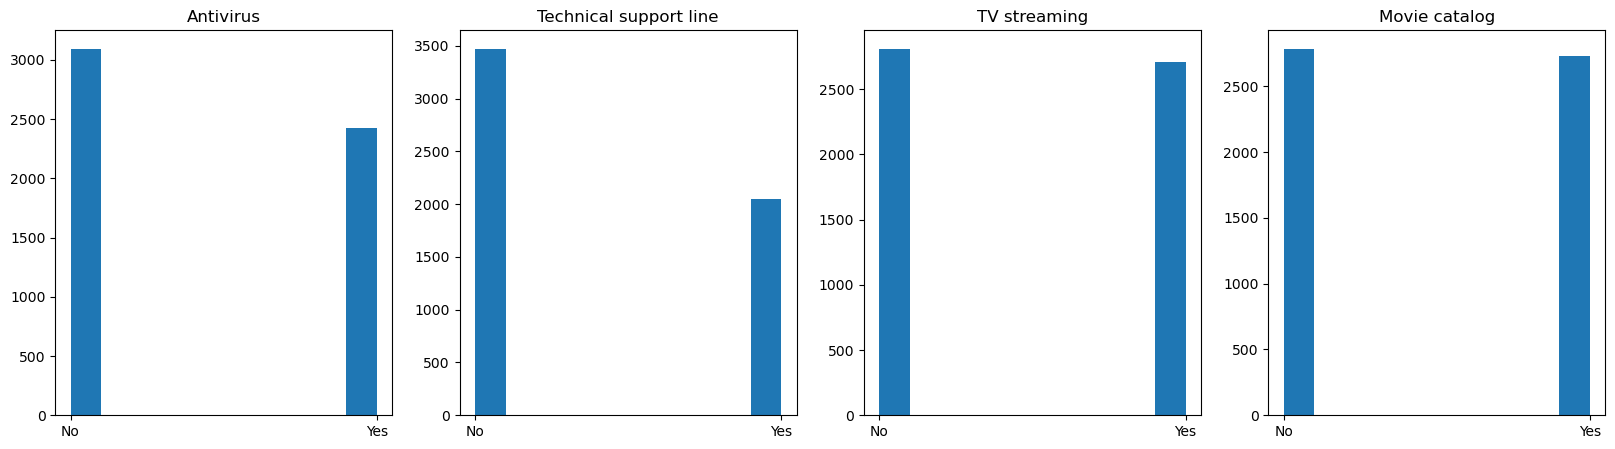

In [11]:
fig, axs = plt.subplots(1, 4, figsize=(20,5))

axs[0].hist(internet['DeviceProtection'], bins = 10, label='x')
axs[0].set_title('Antivirus')

axs[1].hist(internet['TechSupport'], bins = 10, label='x')
axs[1].set_title('Technical support line')

axs[2].hist(internet['StreamingTV'], bins = 10, label='x')
axs[2].set_title('TV streaming')

axs[3].hist(internet['StreamingMovies'], bins = 10, label='x')
axs[3].set_title('Movie catalog')

plt.show()

**Conclusions on the Internet dataset**
* No gaps were found in the data. 
* There are 7 binary variables. 
* Customers do not actively use the company's additional services.

In [12]:
analysis(personal)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes
7039,2234-XADUH,Female,0,Yes,Yes
7040,4801-JZAZL,Female,0,Yes,Yes
7041,8361-LTMKD,Male,1,Yes,No


,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


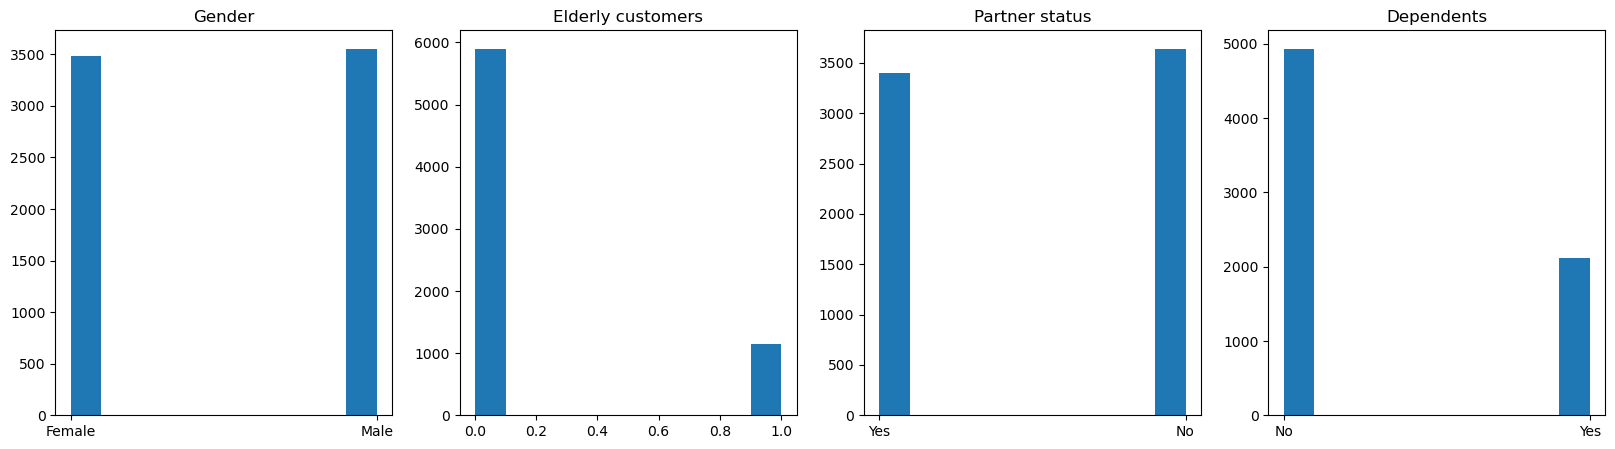

In [13]:
fig, axs = plt.subplots(1, 4, figsize=(20,5))

axs[0].hist(personal['gender'], bins = 10, label='x')
axs[0].set_title('Gender')

axs[1].hist(personal['SeniorCitizen'], bins = 10, label='x')
axs[1].set_title('Elderly customers')

axs[2].hist(personal['Partner'], bins = 10, label='x')
axs[2].set_title('Partner status')

axs[3].hist(personal['Dependents'], bins = 10, label='x')
axs[3].set_title('Dependents')

plt.show()

**Conclusions on the "Personal" dataset**
* No gaps were found in the data.
* Almost all variables are binary.
* From the point of view of gender and the presence of a partner, the data are distributed relatively evenly.

In [14]:
analysis(phone)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
...,...,...
6356,2569-WGERO,No
6357,6840-RESVB,Yes
6358,2234-XADUH,Yes
6359,8361-LTMKD,Yes


,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,5575-GNVDE,No
freq,1,3390


Text(0.5, 1.0, 'Connecting to multiple lines')

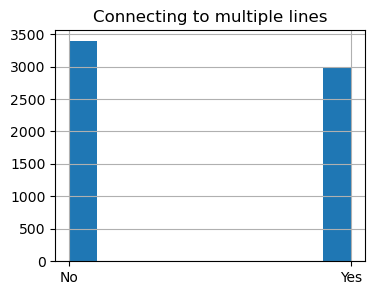

In [15]:
phone['MultipleLines'].hist(figsize=(4, 3), label='x').set_title('Connecting to multiple lines')

**Conclusions on the "Phone" dataset**
* No gaps were found in the data.
* Less than half of the company's customers use the ability to connect to multiple lines at the same time.

### New features adding

1. Let's work with dates

In the `EndDate` column, replace all 'No' values with the latest date from which the dataset was extracted. This will provide us with information about those who are still customers of the company.
Convert both columns (contract start and end dates) to the relevant data type.

In [16]:
#replacing "no" on dates
contract['EndDate'] = contract['EndDate'].replace(['No'], ['2020-02-01'])

In [17]:
#bringing the data to the current formats
contract['BeginDate'] = pd.to_datetime(contract['BeginDate'], format='%Y-%m-%d')
contract['EndDate'] = pd.to_datetime(contract['EndDate'], format='%Y-%m-%d')

2. By having the contract start and end dates, it's easy to calculate the contract duration, which will eventually become a more informative variable for model building.

In [18]:
#creating a variable with the duration of the contract
contract['ContractPeriod'] = (contract['EndDate'] - contract['BeginDate']).dt.days

3. However, we will be predicting the 'churn' of the customer, so we will extract it separately based on the Enddate variable.

In [19]:
#creating the target variable
contract['Churn'] = (contract['EndDate'] != '2020-02-01').astype(int)
contract.head(20)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,ContractPeriod,Churn
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,31,0
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,1036,0
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,123,0
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.6,1371,0
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.5,153,0
5,9305-CDSKC,2019-03-01,2020-02-01,Month-to-month,Yes,Electronic check,99.65,1150.96,337,0
6,1452-KIOVK,2018-04-01,2020-02-01,Month-to-month,Yes,Credit card (automatic),89.10,2058.21,671,0
7,6713-OKOMC,2019-04-01,2020-02-01,Month-to-month,No,Mailed check,29.75,300.48,306,0
8,7892-POOKP,2017-07-01,2020-02-01,Month-to-month,Yes,Electronic check,104.80,3573.68,945,0
9,6388-TABGU,2014-12-01,2017-05-01,One year,No,Bank transfer (automatic),56.15,1628.35,882,1


4. It also makes sense to convert the variable representing total customer payments to a more relevant data type.

In [20]:
contract['TotalCharges'] = pd.to_numeric(contract['TotalCharges'], errors='coerce')

In [21]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   ContractPeriod    7043 non-null   int64         
 9   Churn             7043 non-null   int64         
dtypes: datetime64[ns](2), float64(2), int64(2), object(4)
memory usage: 550.4+ KB


5. In order not to lose information about which customers use internet services or telephone services, additional variables will be created before merging all the data.

In [22]:
internet['Internet_yes'] = 1
phone['Phone_yes'] = 1

### Data integration

In [23]:
data = contract.copy()

In [24]:
data = data.merge(personal, how='left', on='customerID')
data = data.merge(internet, how='left', on='customerID')
data = data.merge(phone, how='left', on='customerID')

In [25]:
data['customerID'].is_unique

True

CustomerID will be used as the basis for the index.

In [26]:
data = data.set_index('customerID')

In [27]:
data.head()

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,ContractPeriod,Churn,gender,...,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Internet_yes,MultipleLines,Phone_yes
customerID,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,31,0,Female,...,DSL,No,Yes,No,No,No,No,1.0,NaN,NaN
5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,1036,0,Male,...,DSL,Yes,No,Yes,No,No,No,1.0,No,1.0
3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,123,0,Male,...,DSL,Yes,Yes,No,No,No,No,1.0,No,1.0
7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,1371,0,Male,...,DSL,Yes,No,Yes,Yes,No,No,1.0,NaN,NaN
9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,153,0,Female,...,Fiber optic,No,No,No,No,No,No,1.0,No,1.0


In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   datetime64[ns]
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7032 non-null   float64       
 7   ContractPeriod    7043 non-null   int64         
 8   Churn             7043 non-null   int64         
 9   gender            7043 non-null   object        
 10  SeniorCitizen     7043 non-null   int64         
 11  Partner           7043 non-null   object        
 12  Dependents        7043 non-null   object        
 13  InternetService   5517 non-null   object        
 14  OnlineSecurity

### Handling missing values

1. There is a different number of values in the `TotalCharges` variable. Let's check the variable for missing values and replace them with 0.

In [29]:
data['TotalCharges'].isnull().sum()

11

In [30]:
display(data[data['TotalCharges'].isnull()])

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,ContractPeriod,Churn,gender,...,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Internet_yes,MultipleLines,Phone_yes
customerID,,,,,,,,,,,,,,,,,,,,,
4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,NaN,0,0,Female,...,DSL,Yes,No,Yes,Yes,Yes,No,1.0,NaN,NaN
3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,NaN,0,0,Male,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,1.0
5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,NaN,0,0,Female,...,DSL,Yes,Yes,Yes,No,Yes,Yes,1.0,No,1.0
4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,NaN,0,0,Male,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,1.0
1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,NaN,0,0,Female,...,DSL,Yes,Yes,Yes,Yes,Yes,No,1.0,NaN,NaN
7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,NaN,0,0,Male,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,1.0
3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,NaN,0,0,Male,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,1.0
2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,NaN,0,0,Female,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,1.0
2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,NaN,0,0,Male,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,1.0


In [31]:
data['TotalCharges'] = data['TotalCharges'].fillna(0)
data['TotalCharges'].isnull().sum()

0

2. There are also some missing values in features related to additional services. It can be assumed that if there is a missing value, the services were not subscribed by the customer. In such cases, we will replace them with 'No'.

In [32]:
for column in ('InternetService', 'OnlineSecurity','OnlineBackup', 'DeviceProtection', 
               'TechSupport', 'StreamingTV','StreamingMovies', 'MultipleLines'):
    data[column] = data[column].fillna('No')

3. Likewise, for the columns created above, the missing values will be filled with 0, indicating that the customer does not use internet or telephone services.

In [33]:
for column in ('Internet_yes','Phone_yes'):
    data[column] = data[column].fillna(0)

In [34]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   datetime64[ns]
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7043 non-null   float64       
 7   ContractPeriod    7043 non-null   int64         
 8   Churn             7043 non-null   int64         
 9   gender            7043 non-null   object        
 10  SeniorCitizen     7043 non-null   int64         
 11  Partner           7043 non-null   object        
 12  Dependents        7043 non-null   object        
 13  InternetService   7043 non-null   object        
 14  OnlineSecurity

In [35]:
data.head()

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,ContractPeriod,Churn,gender,...,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Internet_yes,MultipleLines,Phone_yes
customerID,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,31,0,Female,...,DSL,No,Yes,No,No,No,No,1.0,No,0.0
5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,1036,0,Male,...,DSL,Yes,No,Yes,No,No,No,1.0,No,1.0
3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,123,0,Male,...,DSL,Yes,Yes,No,No,No,No,1.0,No,1.0
7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,1371,0,Male,...,DSL,Yes,No,Yes,Yes,No,No,1.0,No,0.0
9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,153,0,Female,...,Fiber optic,No,No,No,No,No,No,1.0,No,1.0


## Data Analysis

### Visualization of all key features

Let's assess the distribution of quantitative features: `MonthlyCharges`, `TotalCharges`, `ContractPeriod`.

/var/folders/s9/2dhk92k53t10g5010dcth9r80000gn/T/ipykernel_4369/575962767.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['MonthlyCharges'], hist=True, kde=True,


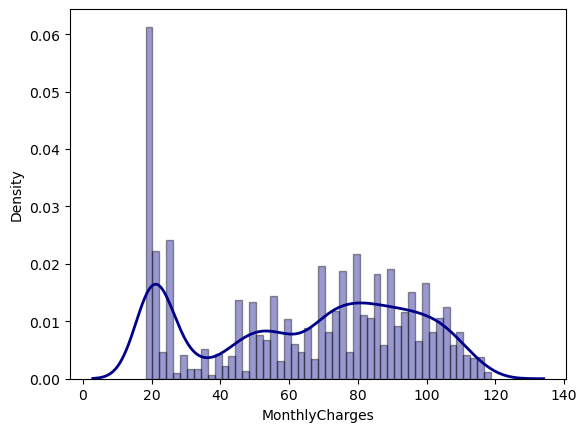

/var/folders/s9/2dhk92k53t10g5010dcth9r80000gn/T/ipykernel_4369/575962767.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['TotalCharges'], hist=True, kde=True,


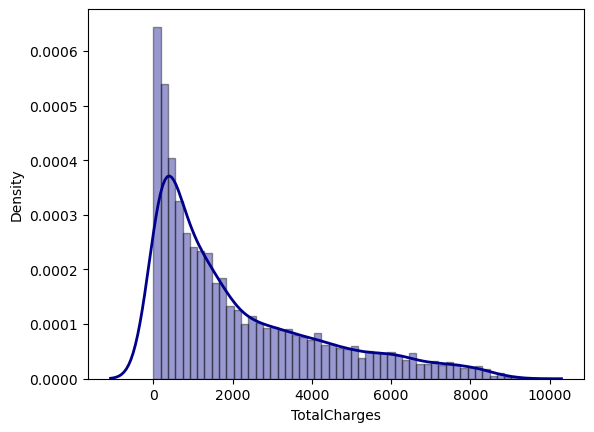

/var/folders/s9/2dhk92k53t10g5010dcth9r80000gn/T/ipykernel_4369/575962767.py:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['ContractPeriod'], hist=True, kde=True,


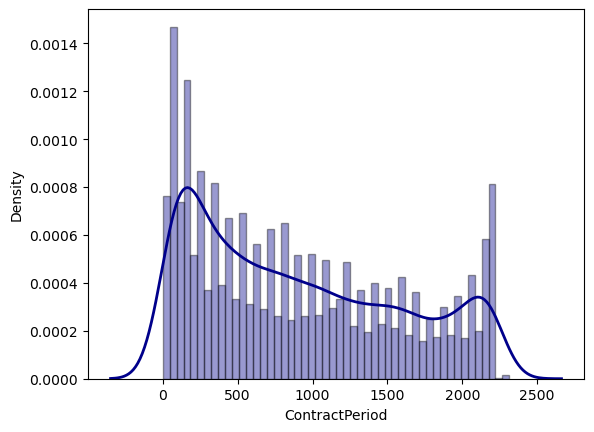

In [36]:
sns.distplot(data['MonthlyCharges'], hist=True, kde=True, 
             bins=50, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})
plt.show()
sns.distplot(data['TotalCharges'], hist=True, kde=True, 
             bins=50, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})
plt.show()
sns.distplot(data['ContractPeriod'], hist=True, kde=True, 
             bins=50, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})

plt.show()

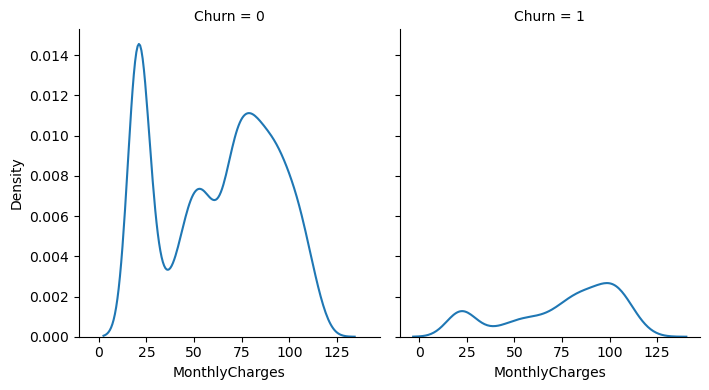

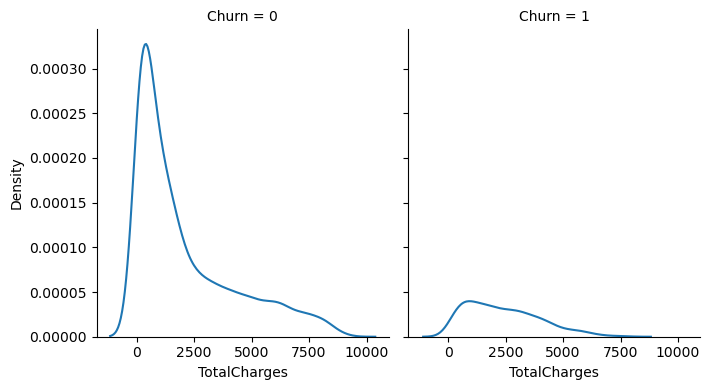

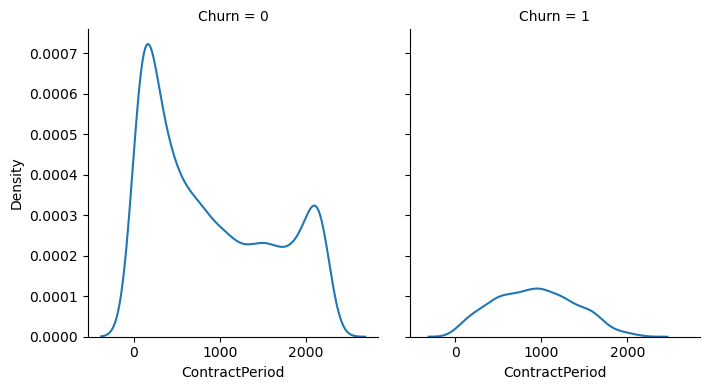

In [37]:
sns.displot(
    data=data, x="MonthlyCharges", col="Churn",
    kind="kde", height=4, aspect=.9,
)
plt.show()
sns.displot(
    data=data, x="TotalCharges", col="Churn",
    kind="kde", height=4, aspect=.9,
)
plt.show()
sns.displot(
    data=data, x="ContractPeriod", col="Churn",
    kind="kde", height=4, aspect=.9,
)
plt.show()

### Variable correlations variables

Проверим переменные на возможную корреляцию.

In [38]:
data[['MonthlyCharges', 'TotalCharges', 'ContractPeriod']].corr()

,MonthlyCharges,TotalCharges,ContractPeriod
MonthlyCharges,1.000000,0.630440,0.220054
TotalCharges,0.630440,1.000000,0.821746
ContractPeriod,0.220054,0.821746,1.000000


Есть ожидаемая проблема мультиколлинеарности между суммарными платежами и длительностью контракта => логично: дольше с компанией, больше платит

##  Data preparation for training

### Removal of unnecessary variables

After the analysis conducted above, it can be concluded that the following variables need to be removed:
1. `Begindate` and `Enddate`
2. `TotalCharges`

In [39]:
data_f = data.copy()

In [40]:
data_f.drop(['BeginDate', 'EndDate', 'TotalCharges'], axis='columns', inplace=True)

In [41]:
data_f.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7043 non-null   object 
 1   PaperlessBilling  7043 non-null   object 
 2   PaymentMethod     7043 non-null   object 
 3   MonthlyCharges    7043 non-null   float64
 4   ContractPeriod    7043 non-null   int64  
 5   Churn             7043 non-null   int64  
 6   gender            7043 non-null   object 
 7   SeniorCitizen     7043 non-null   int64  
 8   Partner           7043 non-null   object 
 9   Dependents        7043 non-null   object 
 10  InternetService   7043 non-null   object 
 11  OnlineSecurity    7043 non-null   object 
 12  OnlineBackup      7043 non-null   object 
 13  DeviceProtection  7043 non-null   object 
 14  TechSupport       7043 non-null   object 
 15  StreamingTV       7043 non-null   object 
 16  StreamingMovies   7043 non-null 

### Processing of categorical variables

Let's transform all categorical variables using One-Hot Encoding (OHE).

In [42]:
data_f = pd.get_dummies(data_f, drop_first=True)

In [43]:
data_f.head()

,MonthlyCharges,ContractPeriod,Churn,SeniorCitizen,Internet_yes,Phone_yes,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),...,Dependents_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,MultipleLines_Yes
customerID,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,29.85,31,0,0,1.0,0.0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
5575-GNVDE,56.95,1036,0,0,1.0,1.0,1,0,0,0,...,0,0,0,1,0,1,0,0,0,0
3668-QPYBK,53.85,123,0,0,1.0,1.0,0,0,1,0,...,0,0,0,1,1,0,0,0,0,0
7795-CFOCW,42.30,1371,0,0,1.0,0.0,1,0,0,0,...,0,0,0,1,0,1,1,0,0,0
9237-HQITU,70.70,153,0,0,1.0,1.0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0


### Division of training and testing datasets

In [44]:
X = data_f.drop(columns=['Churn'])
y = data_f['Churn'] 

In [45]:
RANDOM_STATE = 220523

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y)

In [47]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(5282, 23)
(1761, 23)
(5282,)
(1761,)


In [48]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5282 entries, 7503-ZGUZJ to 7480-QNVZJ
Data columns (total 23 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   MonthlyCharges                         5282 non-null   float64
 1   ContractPeriod                         5282 non-null   int64  
 2   SeniorCitizen                          5282 non-null   int64  
 3   Internet_yes                           5282 non-null   float64
 4   Phone_yes                              5282 non-null   float64
 5   Type_One year                          5282 non-null   uint8  
 6   Type_Two year                          5282 non-null   uint8  
 7   PaperlessBilling_Yes                   5282 non-null   uint8  
 8   PaymentMethod_Credit card (automatic)  5282 non-null   uint8  
 9   PaymentMethod_Electronic check         5282 non-null   uint8  
 10  PaymentMethod_Mailed check             5282 non-null   uint8  

### Processing of quantitative variables

Standardizing all quantitative variables.

In [49]:
numeric=['MonthlyCharges', 'ContractPeriod']
scaler = StandardScaler()

scaler.fit(X_train[numeric])

X_train = X_train.copy()
X_train[numeric] = scaler.transform(X_train[numeric])

X_test = X_test.copy()
X_test[numeric] = scaler.transform(X_test[numeric])

### Class imbalance check 

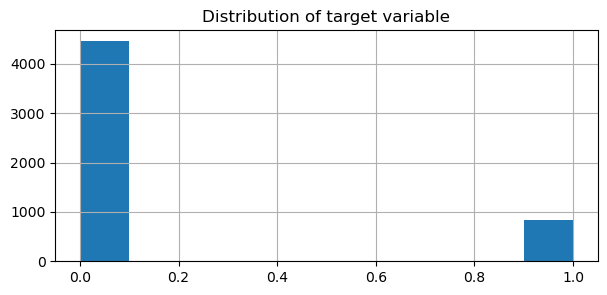

In [50]:
y_train.hist(bins = 10, figsize=(7, 3), label='x').set_title('Distribution of target variable')
plt.show()

It's evident that the target variable is imbalanced; this will need to be taken into account in the parameters of the models used.

## Model training

Three models will be considered below: RandomClassifier, CastBoostClassifier, LightGBM.

### RandomForestClassifier

In [51]:
%%time
params_rf = {
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [2, 10],
    'n_estimators': [10, 50, 100]}

model_rf = RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced')

rf = GridSearchCV(model_rf, 
                  params_rf, 
                  cv=5, 
                  n_jobs=-1, 
                  scoring='roc_auc',
                 verbose = True)
rf.fit(X_train, y_train)

print(rf.best_params_)

pred_proba_rf = rf.best_estimator_.predict_proba(X_train)[:, 1]
auc_rf = roc_auc_score(y_train, pred_proba_rf)
print('ROC-AUC: ', auc_rf)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
{'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 100}
ROC-AUC:  0.912257624727766
CPU times: user 1.35 s, sys: 225 ms, total: 1.58 s
Wall time: 6.57 s


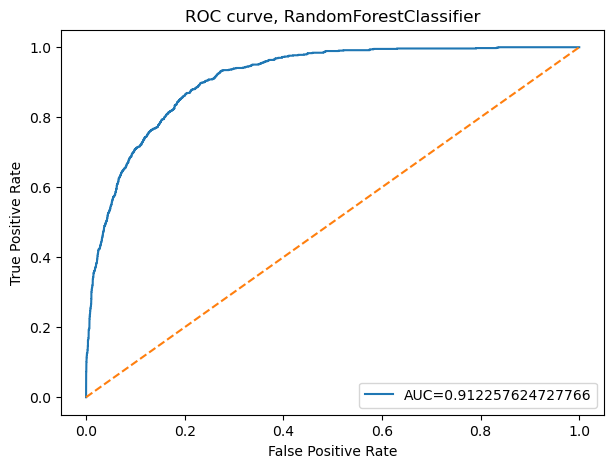

In [52]:
fpr, tpr, thresholds = roc_curve(y_train,  pred_proba_rf)

plt.figure(figsize=(7, 5))

plt.plot(fpr,tpr, label="AUC="+str(auc_rf))
plt.plot([0, 1], [0, 1], linestyle='--')

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.legend(loc=4)
plt.title('ROC curve, RandomForestClassifier')
plt.show()

### CatBoostClassifier

Since we are dealing with imbalanced data, we will introduce the parameter `scale_pos_weight`. In our case, the ratio of 'minority' to 'majority' is approximately 5 (4456/826).

In [53]:
model_cb = CatBoostClassifier(random_state=RANDOM_STATE, loss_function='Logloss', 
                             scale_pos_weight = 5)
params_cb = [{'learning_rate':[0.1, 0.5, 0.9],
             'depth': [4,5,6,7,8,9, 10],
             'iterations': [10, 20,30]}]

cb = GridSearchCV(model_cb,
                  params_cb,
                  verbose = True,
                  cv = 5, 
                  n_jobs=-1, 
                  scoring='roc_auc')

cb.fit(X_train, y_train)

print(cb.best_params_)

pred_proba_cb = cb.best_estimator_.predict_proba(X_train)[:, 1]
auc_cb = roc_auc_score(y_train, pred_proba_cb)

print('ROC-AUC: ',auc_cb)

Fitting 5 folds for each of 63 candidates, totalling 315 fits
0:	learn: 0.6663332	total: 61.5ms	remaining: 554ms
1:	learn: 0.6426486	total: 63.8ms	remaining: 255ms
2:	learn: 0.6245920	total: 66.7ms	remaining: 156ms
3:	learn: 0.6099760	total: 67.9ms	remaining: 102ms
4:	learn: 0.5961260	total: 68.9ms	remaining: 68.9ms
5:	learn: 0.5881760	total: 69.9ms	remaining: 46.6ms
6:	learn: 0.5778453	total: 70.8ms	remaining: 30.4ms
7:	learn: 0.5706713	total: 71.8ms	remaining: 18ms
8:	learn: 0.5632321	total: 72.8ms	remaining: 8.09ms
9:	learn: 0.5560329	total: 73.9ms	remaining: 0us
0:	learn: 0.5776393	total: 2.33ms	remaining: 21ms
1:	learn: 0.5218682	total: 5.26ms	remaining: 21ms
2:	learn: 0.5053724	total: 6.27ms	remaining: 14.6ms
3:	learn: 0.4986180	total: 7.26ms	remaining: 10.9ms
4:	learn: 0.4896440	total: 8.28ms	remaining: 8.28ms
5:	learn: 0.4861990	total: 9.16ms	remaining: 6.11ms
6:	learn: 0.4798078	total: 10.1ms	remaining: 4.34ms
7:	learn: 0.4771970	total: 11.1ms	remaining: 2.76ms
8:	learn: 0.473

0:	learn: 0.6122449	total: 61.4ms	remaining: 552ms
1:	learn: 0.5499942	total: 63.1ms	remaining: 252ms
2:	learn: 0.5402570	total: 65ms	remaining: 152ms
3:	learn: 0.5209038	total: 66.1ms	remaining: 99.1ms
4:	learn: 0.5041223	total: 67.1ms	remaining: 67.1ms
5:	learn: 0.4988284	total: 69.3ms	remaining: 46.2ms
6:	learn: 0.4897901	total: 70.3ms	remaining: 30.1ms
7:	learn: 0.4867858	total: 71.3ms	remaining: 17.8ms
8:	learn: 0.4816209	total: 72.3ms	remaining: 8.03ms
9:	learn: 0.4784431	total: 73.3ms	remaining: 0us
0:	learn: 0.6683086	total: 1.18ms	remaining: 22.4ms
1:	learn: 0.6466330	total: 3.37ms	remaining: 30.4ms
2:	learn: 0.6263222	total: 6ms	remaining: 34ms
3:	learn: 0.6135043	total: 8.82ms	remaining: 35.3ms
4:	learn: 0.5991468	total: 9.82ms	remaining: 29.5ms
5:	learn: 0.5908522	total: 10.9ms	remaining: 25.5ms
6:	learn: 0.5789385	total: 12.5ms	remaining: 23.2ms
7:	learn: 0.5674872	total: 13.5ms	remaining: 20.3ms
8:	learn: 0.5599186	total: 14.5ms	remaining: 17.7ms
9:	learn: 0.5532131	total

0:	learn: 0.6712221	total: 61.3ms	remaining: 552ms
1:	learn: 0.6472030	total: 63.5ms	remaining: 254ms
2:	learn: 0.6259658	total: 65.5ms	remaining: 153ms
3:	learn: 0.6117654	total: 66.4ms	remaining: 99.7ms
4:	learn: 0.5997809	total: 68ms	remaining: 68ms
5:	learn: 0.5903544	total: 70.4ms	remaining: 46.9ms
6:	learn: 0.5784844	total: 72.7ms	remaining: 31.2ms
7:	learn: 0.5695560	total: 74.7ms	remaining: 18.7ms
8:	learn: 0.5635355	total: 76.2ms	remaining: 8.46ms
9:	learn: 0.5539230	total: 77.8ms	remaining: 0us
0:	learn: 0.5701338	total: 1.31ms	remaining: 11.8ms
1:	learn: 0.5296621	total: 2.28ms	remaining: 9.12ms
2:	learn: 0.5062589	total: 3.24ms	remaining: 7.56ms
3:	learn: 0.4941641	total: 4.21ms	remaining: 6.32ms
4:	learn: 0.4879550	total: 5.33ms	remaining: 5.33ms
5:	learn: 0.4851206	total: 7.29ms	remaining: 4.86ms
6:	learn: 0.4745474	total: 9.71ms	remaining: 4.16ms
7:	learn: 0.4685914	total: 11.3ms	remaining: 2.82ms
8:	learn: 0.4644092	total: 12.5ms	remaining: 1.39ms
9:	learn: 0.4585333	to

9:	learn: 0.4718032	total: 17.5ms	remaining: 0us
0:	learn: 0.6663332	total: 1.19ms	remaining: 22.7ms
1:	learn: 0.6426486	total: 2.19ms	remaining: 19.8ms
2:	learn: 0.6245920	total: 3.17ms	remaining: 17.9ms
3:	learn: 0.6099760	total: 4.15ms	remaining: 16.6ms
4:	learn: 0.5961260	total: 5.14ms	remaining: 15.4ms
5:	learn: 0.5881760	total: 6.11ms	remaining: 14.2ms
6:	learn: 0.5778453	total: 7.1ms	remaining: 13.2ms
7:	learn: 0.5706713	total: 8.08ms	remaining: 12.1ms
8:	learn: 0.5632321	total: 9.09ms	remaining: 11.1ms
9:	learn: 0.5560329	total: 11ms	remaining: 11ms
10:	learn: 0.5493195	total: 12ms	remaining: 9.79ms
11:	learn: 0.5452261	total: 13.7ms	remaining: 9.12ms
12:	learn: 0.5406352	total: 14.7ms	remaining: 7.94ms
13:	learn: 0.5359159	total: 18.8ms	remaining: 8.07ms
14:	learn: 0.5318526	total: 19.8ms	remaining: 6.61ms
15:	learn: 0.5275310	total: 20.9ms	remaining: 5.23ms
16:	learn: 0.5236750	total: 23.4ms	remaining: 4.13ms
17:	learn: 0.5212403	total: 25.8ms	remaining: 2.87ms
18:	learn: 0.5

0:	learn: 0.6683086	total: 61.9ms	remaining: 557ms
1:	learn: 0.6466330	total: 63.6ms	remaining: 254ms
2:	learn: 0.6263222	total: 64.9ms	remaining: 151ms
3:	learn: 0.6135043	total: 67.1ms	remaining: 101ms
4:	learn: 0.5991468	total: 68.1ms	remaining: 68.1ms
5:	learn: 0.5908522	total: 72.1ms	remaining: 48.1ms
6:	learn: 0.5789385	total: 73.2ms	remaining: 31.4ms
7:	learn: 0.5674872	total: 74.2ms	remaining: 18.5ms
8:	learn: 0.5599186	total: 76.1ms	remaining: 8.45ms
9:	learn: 0.5532131	total: 77.4ms	remaining: 0us
0:	learn: 0.5981190	total: 1.12ms	remaining: 10.1ms
1:	learn: 0.5293014	total: 2.09ms	remaining: 8.37ms
2:	learn: 0.5117360	total: 3.08ms	remaining: 7.19ms
3:	learn: 0.5001122	total: 4.06ms	remaining: 6.09ms
4:	learn: 0.4895708	total: 5.93ms	remaining: 5.93ms
5:	learn: 0.4829509	total: 8.43ms	remaining: 5.62ms
6:	learn: 0.4760718	total: 10.7ms	remaining: 4.6ms
7:	learn: 0.4737262	total: 11.8ms	remaining: 2.95ms
8:	learn: 0.4693965	total: 12.8ms	remaining: 1.43ms
9:	learn: 0.4602409	

0:	learn: 0.6189111	total: 57.3ms	remaining: 516ms
1:	learn: 0.5475309	total: 58.3ms	remaining: 233ms
2:	learn: 0.5320733	total: 59.2ms	remaining: 138ms
3:	learn: 0.5178118	total: 61.8ms	remaining: 92.6ms
4:	learn: 0.5067671	total: 63.8ms	remaining: 63.8ms
5:	learn: 0.4979726	total: 66.8ms	remaining: 44.5ms
6:	learn: 0.4918698	total: 68ms	remaining: 29.1ms
7:	learn: 0.4864614	total: 69.5ms	remaining: 17.4ms
8:	learn: 0.4848462	total: 70.5ms	remaining: 7.83ms
9:	learn: 0.4804864	total: 71.7ms	remaining: 0us
0:	learn: 0.5907800	total: 1.47ms	remaining: 13.3ms
1:	learn: 0.5340229	total: 2.46ms	remaining: 9.83ms
2:	learn: 0.5132444	total: 3.44ms	remaining: 8.02ms
3:	learn: 0.5036508	total: 4.41ms	remaining: 6.62ms
4:	learn: 0.4934770	total: 5.38ms	remaining: 5.38ms
5:	learn: 0.4861862	total: 6.44ms	remaining: 4.29ms
6:	learn: 0.4791458	total: 8.22ms	remaining: 3.52ms
7:	learn: 0.4754281	total: 12.6ms	remaining: 3.16ms
8:	learn: 0.4668209	total: 15.5ms	remaining: 1.72ms
9:	learn: 0.4610278	

23:	learn: 0.3619503	total: 71.2ms	remaining: 17.8ms
24:	learn: 0.3548699	total: 74.6ms	remaining: 14.9ms
25:	learn: 0.3499465	total: 77.7ms	remaining: 12ms
26:	learn: 0.3459773	total: 80.3ms	remaining: 8.92ms
27:	learn: 0.3355541	total: 83.9ms	remaining: 5.99ms
28:	learn: 0.3269443	total: 86.4ms	remaining: 2.98ms
29:	learn: 0.3206298	total: 88.5ms	remaining: 0us
0:	learn: 0.5830923	total: 2.18ms	remaining: 63.2ms
1:	learn: 0.5277530	total: 4.53ms	remaining: 63.4ms
2:	learn: 0.5018138	total: 6.5ms	remaining: 58.5ms
3:	learn: 0.4859691	total: 8.47ms	remaining: 55.1ms
4:	learn: 0.4737923	total: 10.5ms	remaining: 52.3ms
5:	learn: 0.4665488	total: 23.1ms	remaining: 92.4ms
6:	learn: 0.4548865	total: 26.7ms	remaining: 87.9ms
7:	learn: 0.4465933	total: 28.9ms	remaining: 79.6ms
8:	learn: 0.4394488	total: 31.4ms	remaining: 73.3ms
9:	learn: 0.4329689	total: 34ms	remaining: 67.9ms
10:	learn: 0.4261037	total: 36.9ms	remaining: 63.8ms
11:	learn: 0.4177047	total: 39.8ms	remaining: 59.7ms
12:	learn: 

5:	learn: 0.3836955	total: 24.1ms	remaining: 16.1ms
6:	learn: 0.3738636	total: 30.2ms	remaining: 12.9ms
7:	learn: 0.3629957	total: 33.4ms	remaining: 8.34ms
8:	learn: 0.3432666	total: 37.5ms	remaining: 4.16ms
9:	learn: 0.3376211	total: 41.3ms	remaining: 0us
0:	learn: 0.5455070	total: 4.04ms	remaining: 36.3ms
1:	learn: 0.4881487	total: 8.03ms	remaining: 32.1ms
2:	learn: 0.4594733	total: 14.6ms	remaining: 34ms
3:	learn: 0.4361013	total: 19.7ms	remaining: 29.6ms
4:	learn: 0.4255845	total: 23.3ms	remaining: 23.3ms
5:	learn: 0.4101931	total: 27.3ms	remaining: 18.2ms
6:	learn: 0.3974240	total: 31.9ms	remaining: 13.7ms
7:	learn: 0.3883784	total: 36.8ms	remaining: 9.19ms
8:	learn: 0.3699780	total: 40.1ms	remaining: 4.46ms
9:	learn: 0.3441655	total: 43.1ms	remaining: 0us
0:	learn: 0.6576676	total: 4.53ms	remaining: 86.1ms
1:	learn: 0.6303995	total: 11.3ms	remaining: 101ms
2:	learn: 0.6024002	total: 16ms	remaining: 90.8ms
3:	learn: 0.5795278	total: 21.1ms	remaining: 84.3ms
4:	learn: 0.5619894	tot

4:	learn: 0.4753308	total: 17.8ms	remaining: 89.1ms
5:	learn: 0.4666256	total: 21.3ms	remaining: 85.2ms
6:	learn: 0.4517458	total: 24.3ms	remaining: 79.8ms
7:	learn: 0.4441332	total: 26.9ms	remaining: 73.9ms
8:	learn: 0.4351585	total: 30.2ms	remaining: 70.4ms
9:	learn: 0.4303599	total: 36.4ms	remaining: 72.7ms
10:	learn: 0.4226504	total: 40.7ms	remaining: 70.3ms
11:	learn: 0.4184043	total: 42.9ms	remaining: 64.3ms
12:	learn: 0.4136537	total: 47.1ms	remaining: 61.6ms
13:	learn: 0.4084069	total: 50.8ms	remaining: 58ms
14:	learn: 0.4037656	total: 52.9ms	remaining: 52.9ms
15:	learn: 0.3993633	total: 57.5ms	remaining: 50.3ms
16:	learn: 0.3931325	total: 61.8ms	remaining: 47.3ms
17:	learn: 0.3851183	total: 66.1ms	remaining: 44.1ms
18:	learn: 0.3763277	total: 68.9ms	remaining: 39.9ms
19:	learn: 0.3698099	total: 71.7ms	remaining: 35.8ms
20:	learn: 0.3609618	total: 75ms	remaining: 32.1ms
21:	learn: 0.3597542	total: 76.5ms	remaining: 27.8ms
22:	learn: 0.3534414	total: 80.9ms	remaining: 24.6ms
23:

0:	learn: 0.5792064	total: 59.7ms	remaining: 1.73s
1:	learn: 0.5349605	total: 61.3ms	remaining: 858ms
2:	learn: 0.5201423	total: 62.6ms	remaining: 564ms
3:	learn: 0.5064104	total: 63.9ms	remaining: 415ms
4:	learn: 0.4947910	total: 65.4ms	remaining: 327ms
5:	learn: 0.4862854	total: 66.5ms	remaining: 266ms
6:	learn: 0.4804688	total: 67.9ms	remaining: 223ms
7:	learn: 0.4750328	total: 69ms	remaining: 190ms
8:	learn: 0.4711552	total: 70.2ms	remaining: 164ms
9:	learn: 0.4670022	total: 71.5ms	remaining: 143ms
10:	learn: 0.4614523	total: 72.8ms	remaining: 126ms
11:	learn: 0.4547286	total: 74ms	remaining: 111ms
12:	learn: 0.4472945	total: 75.5ms	remaining: 98.8ms
13:	learn: 0.4406031	total: 76.9ms	remaining: 87.8ms
14:	learn: 0.4317086	total: 78ms	remaining: 78ms
15:	learn: 0.4238583	total: 79.2ms	remaining: 69.3ms
16:	learn: 0.4210260	total: 80.1ms	remaining: 61.3ms
17:	learn: 0.4126028	total: 81.2ms	remaining: 54.1ms
18:	learn: 0.4054578	total: 82.4ms	remaining: 47.7ms
19:	learn: 0.3993427	to

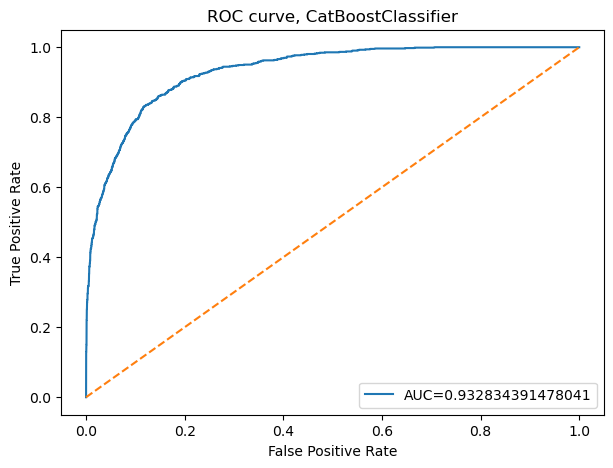

In [54]:
fpr, tpr, thresholds = roc_curve(y_train,  pred_proba_cb)

plt.figure(figsize=(7, 5))

plt.plot(fpr,tpr, label="AUC="+str(auc_cb))
plt.plot([0, 1], [0, 1], linestyle='--')

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.legend(loc=4)
plt.title('ROC curve, CatBoostClassifier')
plt.show()

### LightGBM

In [55]:
%%time


params_lgbm = [{'num_leaves':[50, 100, 200], 
                'learning_rate':[0.1, 0.3, 0.5],
                'max_depth': [2]}]

model_lgbm = lgb.LGBMClassifier(random_state=RANDOM_STATE,
                                loss_function='Logloss',
                                scale_pos_weight = 5) 

lgbm = GridSearchCV(model_lgbm,
                    params_lgbm,
                    n_jobs=-1,
                    cv = 5,
                    scoring='roc_auc')
lgbm.fit(X_train, y_train)

print(lgbm.best_params_)

pred_proba_lgbm = lgbm.best_estimator_.predict_proba(X_train)[:, 1]
auc_lgbm = roc_auc_score(y_train, pred_proba_lgbm)

print('ROC-AUC: ', auc_lgbm)

5:	learn: 0.4101931	total: 30ms	remaining: 69.9ms
6:	learn: 0.3974240	total: 36.1ms	remaining: 67ms
7:	learn: 0.3883784	total: 39.3ms	remaining: 58.9ms
8:	learn: 0.3699780	total: 42.8ms	remaining: 52.4ms
9:	learn: 0.3441655	total: 45.8ms	remaining: 45.8ms
10:	learn: 0.3307161	total: 51ms	remaining: 41.7ms
11:	learn: 0.3171631	total: 56.7ms	remaining: 37.8ms
12:	learn: 0.3015275	total: 60.2ms	remaining: 32.4ms
13:	learn: 0.2920502	total: 64.6ms	remaining: 27.7ms
14:	learn: 0.2805859	total: 69.9ms	remaining: 23.3ms
15:	learn: 0.2735457	total: 76.5ms	remaining: 19.1ms
16:	learn: 0.2638872	total: 80.7ms	remaining: 14.2ms
17:	learn: 0.2553016	total: 84.7ms	remaining: 9.41ms
18:	learn: 0.2457678	total: 90.8ms	remaining: 4.78ms
19:	learn: 0.2348803	total: 95.2ms	remaining: 0us
0:	learn: 0.6576676	total: 3.61ms	remaining: 105ms
1:	learn: 0.6303995	total: 7.34ms	remaining: 103ms
2:	learn: 0.6024002	total: 12.5ms	remaining: 112ms
3:	learn: 0.5795278	total: 18.7ms	remaining: 121ms
4:	learn: 0.561

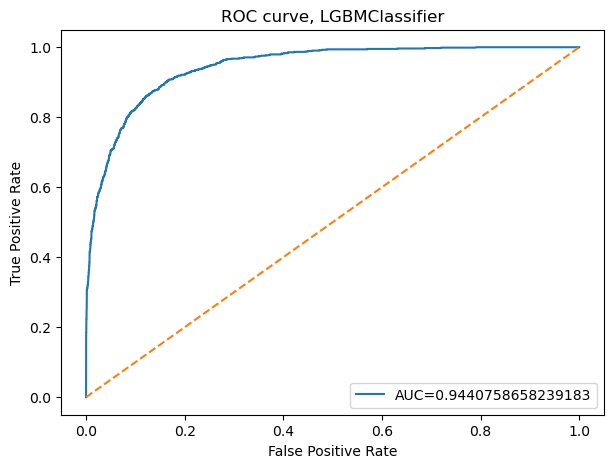

In [56]:
fpr, tpr, thresholds = roc_curve(y_train,  pred_proba_lgbm)

plt.figure(figsize=(7, 5))

plt.plot(fpr,tpr, label="AUC="+str(auc_lgbm))
plt.plot([0, 1], [0, 1], linestyle='--')

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.legend(loc=4)
plt.title('ROC curve, LGBMClassifier')
plt.show()

### Selection of the best model

The best result in terms of the AUC metric was demonstrated by the LGBMClassifier. Let's test the best model on the test dataset.

In [57]:
model_lgbm_best = lgb.LGBMClassifier(learning_rate=0.5, 
                                  max_depth = 2,
                                  num_leaves = 50,
                                  random_state=RANDOM_STATE, 
                                  verbose=1) 
model_lgbm_best.fit(X_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 826, number of negative: 4456
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001092 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 478
[LightGBM] [Info] Number of data points in the train set: 5282, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.156380 -> initscore=-1.685412
[LightGBM] [Info] Start training from score -1.685412


LGBMClassifier(learning_rate=0.5, max_depth=2, num_leaves=50,
               random_state=220523, verbose=1)

In [58]:
pred_proba_lgbm_test = model_lgbm_best.predict_proba(X_test)[:, 1]
auc_lgbm_best = roc_auc_score(y_test, pred_proba_lgbm_test)

print('ROC-AUC: ', auc_lgbm_best)

ROC-AUC:  0.9059965740854031


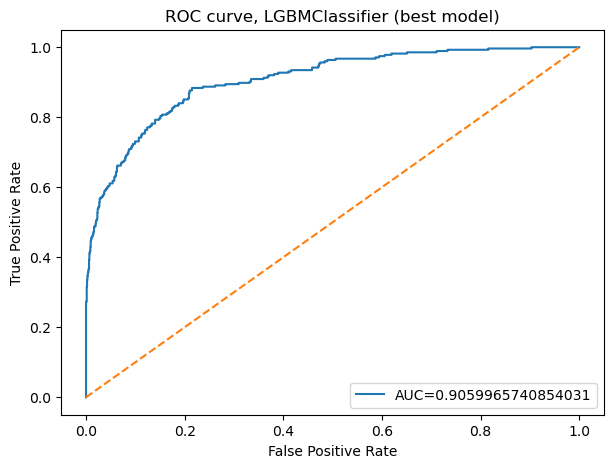

In [59]:
fpr, tpr, thresholds = roc_curve(y_test, pred_proba_lgbm_test)

plt.figure(figsize=(7, 5))

plt.plot(fpr,tpr, label="AUC="+str(auc_lgbm_best))
plt.plot([0, 1], [0, 1], linestyle='--')

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.legend(loc=4)
plt.title('ROC curve, LGBMClassifier (best model)')
plt.show()

## Conclusion

The presented study conducted an analysis and trained models for predicting customer churn for the telecommunications operator.

At the outset, the following data was obtained:

- Dataset with customer contract information
- Dataset with customer personal data information
- Dataset with information about internet services
- Dataset with information about telephony services

The key steps of the work that led to achieving a high ROC-AUC value were as follows:

- Thorough analysis of the initial data was conducted: all variables were studied and visualized, checked for missing values, and relevant data types were examined.
- Following the analysis, variable types were adjusted concerning start date ("BeginDate"), contract end date ("EndDate"), and total charges ("TotalCharges"). A significant variable "ContractPeriod" representing the contract duration was added, along with the "Churn" variable (target feature). Additionally, variables indicating the usage of internet services or telephony ("Internet_yes", "Phone_yes") were included to preserve this information after merging the datasets.
- Subsequently, all original datasets were merged into one based on "customerID," which was also designated as the index.
- Missing values were primarily related to binary variables indicating the usage of additional services. These missing values were replaced with "No." For previously created variables regarding service usage ("Internet_yes", "Phone_yes"), gaps were filled with 0, signifying that the customer did not use the services.
- The final model features were: 'Type', 'PaperlessBilling', 'PaymentMethod', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Internet_yes', 'MultipleLines', 'Phone_yes'.
- Data distributions were analyzed, and key observations were noted for two segments: churned and non-churned customers.
- Quantitative features were examined for multicollinearity. High correlation between "TotalCharges" and "ContractPeriod" led to the removal of the "TotalCharges" variable.
- The overall dataset was then split into training and testing sets with a test_size of 0.25.
- Categorical and quantitative variables were separately processed: categorical variables were transformed using the One-Hot-Encoding method, and quantitative variables were scaled.
- The target feature was checked for imbalance. Although significant imbalance was detected, it was considered in each applied model during training.
- Three models were trained: RandomClassifier, CastBoostClassifier, and LightGBM. GridSearchCV was employed in each, and class imbalance was accounted for. CatBoost and LightGBM used the parameter "scale_pos_weight" with a value of 5, as the ratio of "minority" to "majority" classes was approximately 4456/826.
- The best result in terms of ROC-AUC (0.88) was achieved using the LightGBM model.
- The best model was evaluated on the test set, resulting in a ROC-AUC of 0.9, indicating a sufficiently high result and good model performance.